# **Personality prediction based on internet posts**

In this notebook we will investigate data from kaggle Myers-Briggs Personality Type Dataset. Based on information contained in this collection we will try to predict personality type of author of post.

More on test and personality types can be found here: https://www.16personalities.com/personality-types


# Buissnes understanding

Living in the internet world, we read hundreds of posts every day by authors with different views and character traits. Having data that collects posts labeled with the personality type of the user who wrote them I decided to answer the three below questions:

1. What is the distribution of each personality trait among forum users?
2. Are there any most significant word for every trait? Do extroverts write in a different way than introverts? Or maybe people with more sensitive approach are using emotional vocabulary?
3. Can personality type be predicted based on someones post?

Thanks to this recruiters could get to know potential job candidates better, based on the information they have provided about themselves, e.g. on Linkedin. This could also be used on dating sites, where machine learning algorithms could select partners based on their personality, inferred from their descriptions about themselves.

In [2]:
# import all necessary packages
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/oamadeus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oamadeus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data understanding & Data preparation

In [4]:
# load and display data
pd.options.display.max_colwidth = 100

data_df = pd.read_csv("mbti_1.csv")
data_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi do...
8671,ENFP,'So...if this thread already exists someplace else (which it does: http://personalitycafe.com/e...
8672,INTP,'So many questions when i do these things. I would take the purple pill. Pick winning lottery n...
8673,INFP,'I am very conflicted right now when it comes to wanting children. I honestly had no maternal i...


In [5]:
# check if there are missing values
data_df.isna().mean()

type     0.0
posts    0.0
dtype: float64

Dataset consists of 2 columns with 8675 records. Every record contains authors personality type and his or hers published posts. It doesn't have any empty values so we don't need to worry about dropping or imputing missing data.

Let's display first 1000 characters of random record.

In [6]:
random_record = data_df.loc[42]["type"], data_df.loc[42]["posts"]
print("type: ", random_record[0], "\nposts: ", random_record[1][:1000])

type:  INTP 
posts:  Painting the world with the colors of my soul. Interpret it as you like - helping others by volunteering, teaching, giving everything you have.  Personal growth - learning as much about the universe...|||6 months ago I met this ENTP guy at my university. We are in the same group, so we basically have to be together everyday, and most likely have to study together for the next 6 years. So cutting off...|||1984 all the way|||I don't like people in groups because it's harder to enslave them.|||ESxJ or ISxJ, because I've noticed that ISxJs don't have much trouble with small talk either.  I'd say ISTJ.|||secret :)|||I really like the movie, and Alice is my alter ego in internet, since people find my real name a bit weird.|||Sense of smell easily, because my sense of smell has always been kind of weak. I think it's better that way, because I don't feel and suffer from disgusting smells people seem to feel everyday. I...|||I don't think there's a certain type who would te

Ok so before applying any modification to data we check how does the distribution of every type in dataset looks like

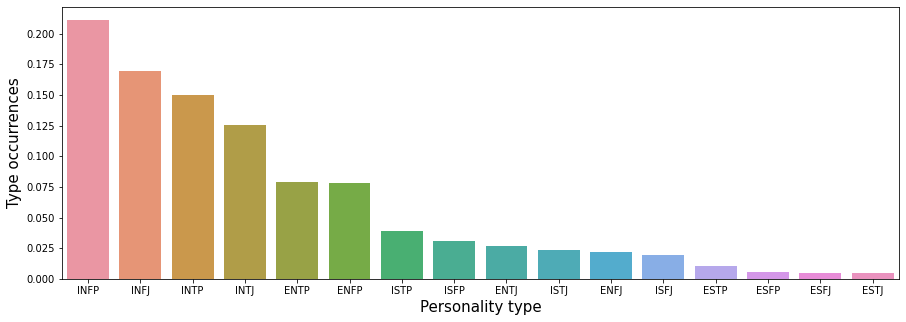

In [7]:
def plot_dist(data_dist, save_fig=False):
    """
    Plots seaborn barplot
    args: data_dist is a dictionary with trait name as key and it's occurences as value
          save_fig is boolean indicating if figure should be saved as png file
    """
    fig = plt.figure(figsize=(15,5))
    sns.barplot(data_dist.index, data_dist.values)
    plt.ylabel('Type occurrences', fontsize=15)
    plt.xlabel('Personality type', fontsize=15)
    
    if save_fig:
        fig.savefig('distribution.png')
        
plot_dist(data_df["type"].value_counts(normalize=True), save_fig=True)

Well this is... interesting. It seems that we have much more introverts going throug life with strong intution (first two letters in personality type) in society. But is this accurate with official statistics? Not really, here: https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm?bhcp=1 we can se that out dataset is not quite representative for whole society and because of that is strongly imbalanced.

According to graphics presented above we should investigate what is the distribution between each singular trait in our data. That means we want to check how looks a ratio:
* introverts to extraverts,
* intuition to sensing,
* feeling to thinking,
* judging to perceiving

To do that, let's encode our labels to categorized values.

In [8]:
def encode(personality):
    """Given string with four uppercase letters, returns list of int values: 1 for every letter (I, N, F, P), 0 otherwise"""
    encoder = defaultdict(int, {"I": 1, "N": 1, "F": 1, "P": 1})
    return [encoder[letter] for letter in list(personality)]

print(encode("ENTP"))
print(encode("ISFJ"))

[0, 1, 0, 1]
[1, 0, 1, 0]


Let's concatenate our dataframes

In [9]:
data_df = pd.concat([pd.DataFrame.from_records(data_df["type"].apply(lambda personality: encode(personality)), columns=["I-E", "N-S", "F-T", "P-J"]), data_df], axis=1)
data_df

,I-E,N-S,F-T,P-J,type,posts
0,1,1,1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,0,1,0,1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,1,1,0,1,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,1,1,0,0,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,0,1,0,0,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...
...,...,...,...,...,...,...
8670,1,0,1,1,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi do...
8671,0,1,1,1,ENFP,'So...if this thread already exists someplace else (which it does: http://personalitycafe.com/e...
8672,1,1,0,1,INTP,'So many questions when i do these things. I would take the purple pill. Pick winning lottery n...
8673,1,1,1,1,INFP,'I am very conflicted right now when it comes to wanting children. I honestly had no maternal i...


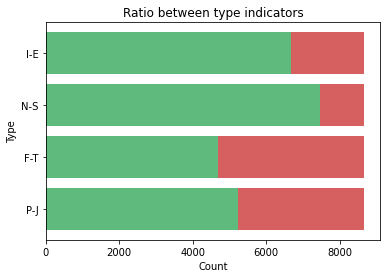

<Figure size 432x288 with 0 Axes>

In [10]:
left = np.array([data_df["I-E"].sum(), data_df["N-S"].sum(), data_df["F-T"].sum(), data_df["P-J"].sum()])
right = np.array([len(data_df)] * 4) - left

coordinates = [3, 2, 1, 0]

p1 = plt.barh(coordinates, left, color=['#5fba7d'])
p2 = plt.barh(coordinates, right, left=left, color=['#d65f5f'])

plt.title("Ratio between type indicators")
plt.xlabel("Count")
plt.ylabel("Type")
plt.yticks(coordinates, ("I-E", "N-S", "F-T", "P-J"))

plt.show()
plt.savefig("ratio.png")

Ok, so we can see that distribution is nothing like provided by test authors. Reason of this incompatibility may be related to fact that introverts are much more focused on their "inside world". So they tended to patricipate and discuss this kind of tests more offen than more expresive colleuges. Although I have no idea why this selected group of people are so insensitive :(

Now we should investigate text data but right now it looks a little bit messy. It seems that every post is separated by "|||" sign and it has a lot of redundant signs and traits which make analisys harder. We should clean up this text.

We would like to get rid of every:
* url
* digits
* non ascii characters
* most common words in certain language

And also:
* lowercase our text
* as well as lemmatize every word

In [11]:
def lemmatize_text(text: str):
    """Applies lemmatisation to every word in given text"""
    lem = WordNetLemmatizer()
    text = text.split(" ")
    text = [lem.lemmatize(word) for word in text]
    
    return " ".join(text)

def remove_stopwords(text, stopwords):
    """Removes most given stopwords from text"""
    text = text.split(" ")
    return " ".join([word for word in text if word not in stopwords])

def preprocess_text(text, stopwords):
    """Applies a series of transformations on given text to normalize it"""
    text = re.sub(r'http\S+', '', text)  # remove url links
    text = re.sub("[^a-zA-Z]", " ", text)  # remove every non ascii character and digit
    text = text.lower()
    text = remove_stopwords(text, stopwords)
    
    text = re.sub(' +', ' ', text)  # remove extra whitespaces
    return text

Let's see how does above function affects out text

In [12]:
eng_stopwords = stopwords.words("english")
personality_types = list({type.lower() for type in set(data_df["type"])})
personality_types.extend([pt + "s" for pt in personality_types]) # a lot of people are using personality type in plural form with extra s at the end, we should remove it as well
my_stopwords = set(eng_stopwords).union(personality_types)  # we don't want to keep personality type acronyms in text, so we add them to stopwords

rnd_idx = np.random.randint(low=0, high=len(data_df)-1, size=2)
for idx in rnd_idx:
    random_record = data_df.loc[idx]["type"], data_df.loc[idx]["posts"]
    print("type: ", random_record[0], "\nposts: ", preprocess_text(random_record[1], my_stopwords), "\n")

type:  INFP 
posts:   roommate happened know anyhow friendship sequence ever feel like yes thought one thought things like get two closest friends x tie proximity x also really good friends another fellow issue murky people commit suicide almost always unimaginably awful emotional place think people commit suicide ever want lives end want communicate kidding one good friends try one size ya think two things allow us private witt ever feel lonely first sgt edward welsh around people thin red line consider loner suffer feelings loneliness consequent parent sometimes houses need cleaned parent super sensitive others needs sibling uh friend world beautiful place friend following welcome tribe buddy people learn explore dark corners difficult times mean deepest thoughts interesting bursts creativity inspired thanks wound taking way personal bend ever intended felt much put public display started writing brief story response picture wound eight pages imagination indeed kind intense basically

It's a lot of text, but it looks much cleaner. Now we will apply this function and clean text for every row in posts column. This may took around minute or two.

In [13]:
data_df["preprocessed_posts"] = data_df["posts"].apply(lambda text: preprocess_text(text, my_stopwords))
data_df

,I-E,N-S,F-T,P-J,type,posts,preprocessed_posts
0,1,1,1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...,moments sportscenter top ten plays pranks life changing experience life repeat today may perc e...
1,0,1,0,1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...,finding lack posts alarming sex boring position often example girlfriend currently environment ...
2,1,1,0,1,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno...",good one course say know blessing curse absolutely positive best friend could amazing couple co...
3,1,1,0,0,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th...",dear enjoyed conversation day esoteric gabbing nature universe idea every rule social code arbi...
4,0,1,0,0,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...,fired another silly misconception approaching logically going key unlocking whatever think enti...
...,...,...,...,...,...,...,...
8670,1,0,1,1,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi do...,always think cats fi doms reason websites become neo nazis perc nerd learning dutch duolingo mu...
8671,0,1,1,1,ENFP,'So...if this thread already exists someplace else (which it does: http://personalitycafe.com/e...,thread already exists someplace else heck delete one ooops guess look hard started movies every...
8672,1,1,0,1,INTP,'So many questions when i do these things. I would take the purple pill. Pick winning lottery n...,many questions things would take purple pill pick winning lottery numbers whatever want worked ...
8673,1,1,1,1,INFP,'I am very conflicted right now when it comes to wanting children. I honestly had no maternal i...,conflicted right comes wanting children honestly maternal instinct whatsoever recently none clo...


We can check what are the most common words between each group.

In [13]:
introverts_vocab = data_df.loc[data_df["I-E"] == 1]["preprocessed_posts"].sum().split(" ")
extraverts_vocab = data_df.loc[data_df["I-E"] == 0]["preprocessed_posts"].sum().split(" ")
feelers_vocab = data_df.loc[data_df["F-T"] == 1]["preprocessed_posts"].sum().split(" ")
thinkers_vocab = data_df.loc[data_df["F-T"] == 0]["preprocessed_posts"].sum().split(" ")

In [14]:
def get_top_n_words(corpus, n=None):
    """Gets n most common words from corpus"""
    words_freq = FreqDist(corpus)
    return words_freq.most_common(n)

In [15]:
def show_most_common_words(vocabulary):
    """Plots most common words in vocabulary as bar plot, with descending order"""
    top_words = get_top_n_words(vocabulary, n=20)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Word", "Freq"]

    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x="Word", y="Freq", data=top_df);
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

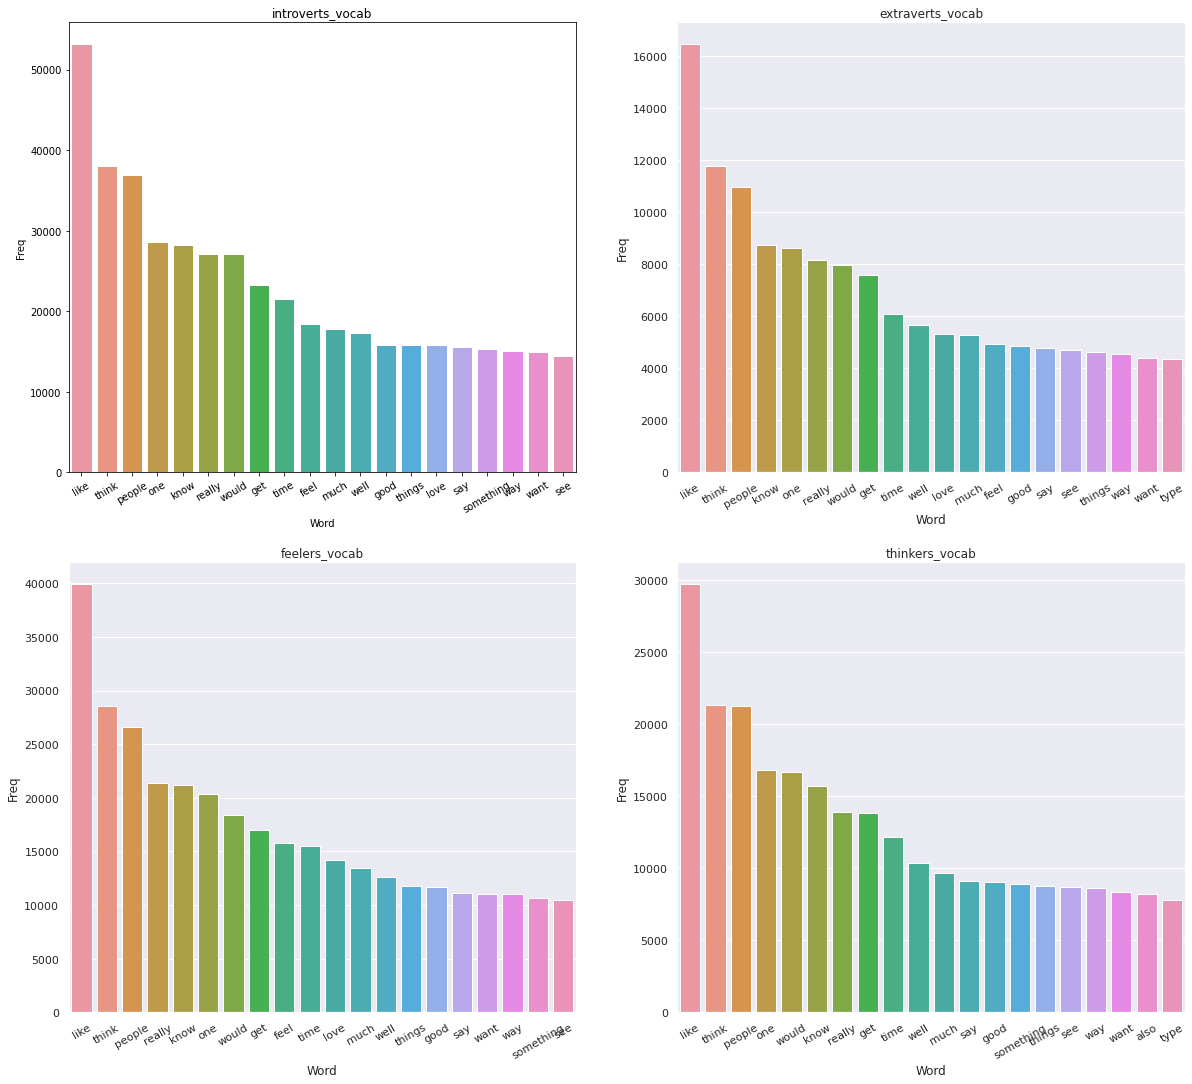

In [16]:
f = plt.figure(figsize=(20,10))
f.tight_layout()

vocab_dict = {
    1: 'introverts_vocab', 
    2: 'extraverts_vocab', 
    3: 'feelers_vocab', 
    4: 'thinkers_vocab'
}

plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=None)

for vocab_num in vocab_dict.keys():
    f.add_subplot(4, 2, vocab_num)
    plt.title(vocab_dict[vocab_num])
    show_most_common_words(eval(vocab_dict[vocab_num]))

So we can see that there is no clearly more popular words for each personality trait. We could remove ones which are most popular among each group, but maybe there is better way. Let's change text representation to numbers.

In [14]:
cv = CountVectorizer(max_df=0.90, max_features=10000, ngram_range=(1,1))
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)

X = cv.fit_transform(data_df["preprocessed_posts"])
feature_names = cv.get_feature_names()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_vector = tfidf_transformer.fit_transform(X)

In [15]:
print(tfidf_vector.todense())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.06302452 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Now when we have our data ready to use with machine learning algorighm we can train our model and see how it's behaves

# Modeling

In [16]:
l_svc = LinearSVC(C=100, verbose=3, max_iter=10000)

In [17]:
X = tfidf_vector
y = data_df["I-E"]

# beacuse of highly imbalanced dataset, we need to use stratify option, to make sure that each class representation will be accurate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# check if data is properly splitted
print(X_train.shape)
print(X_test.shape)

(6940, 10000)
(1735, 10000)


In [18]:
l_svc.fit(X_train, y_train)
y_pred = l_svc.predict(X_test)

[LibLinear]

# Evaluation

Cell below will plot colorful confusion matrix for results predicted by classifier

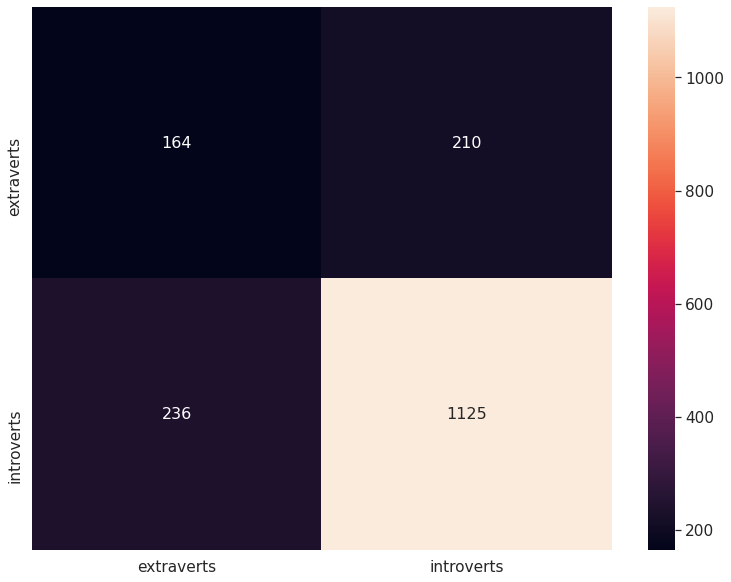

In [19]:
types_list = ["extraverts", "introverts"]
cm = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cm, types_list, types_list)
fig = plt.figure(figsize = (13,10))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()

More detailed report

In [20]:
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.44      0.42       374
           1       0.84      0.83      0.83      1361

    accuracy                           0.74      1735
   macro avg       0.63      0.63      0.63      1735
weighted avg       0.75      0.74      0.75      1735



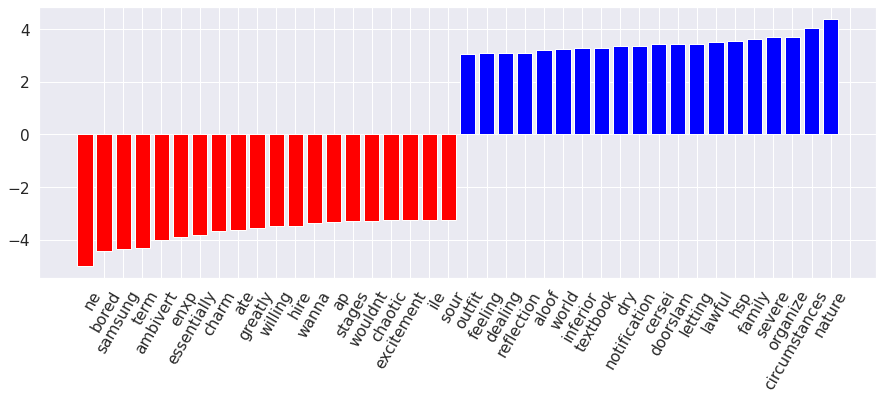

In [21]:
def plot_coefficients(classifier, feature_names, n_features=20):
    """Plots a bar plot with feature importances for provided classifier. To work classifier must have coef_ attribute"""
    coef = classifier.coef_.ravel()
    feature_names = np.array(feature_names)
    
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors)
    plt.xticks(np.arange(1, 1 + 2 * n_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

plot_coefficients(l_svc, cv.get_feature_names())

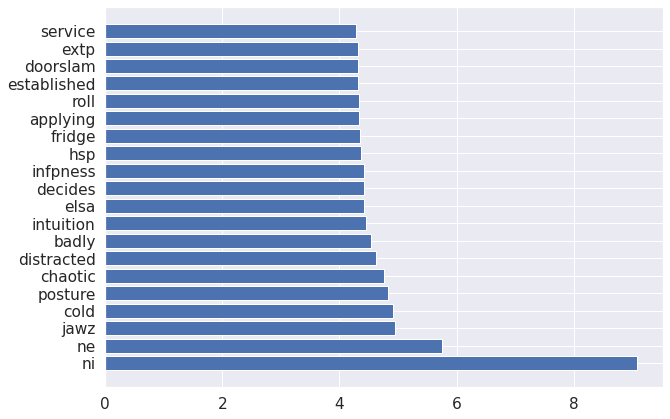

In [33]:
def feature_importances(coef, features_names, n_top=-1):
    """Plots horizontal bar plot with n_top most significant features used in prediction"""
    coef, features_names = zip(*sorted(list(zip(coef, features_names))))

    # Show all features
    if n_top == -1:
        n_top = len(features_names)
    
    plt.rcParams["figure.figsize"] = (10,7)
    plt.barh(range(n_top), coef[::-1][0:n_top], align='center')
    plt.yticks(range(n_top), features_names[::-1][0:n_top])
    plt.show()

feature_importances(abs(l_svc.coef_[0]), cv.get_feature_names(), n_top=20)

Now we will train four different binary classifiers and print classification result for every one of them

Fitting I-E
[LibLinear]
 I-E  report
               precision    recall  f1-score   support

           0       0.42      0.45      0.44       378
           1       0.84      0.83      0.84      1357

    accuracy                           0.75      1735
   macro avg       0.63      0.64      0.64      1735
weighted avg       0.75      0.75      0.75      1735



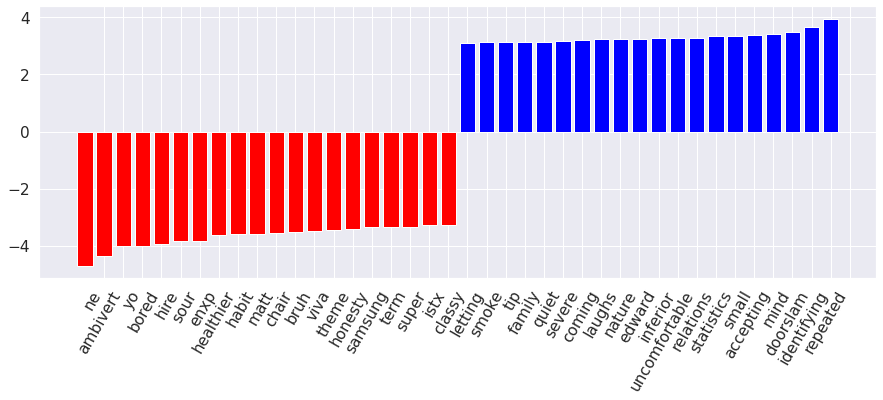

Fitting N-S
[LibLinear]
 N-S  report
               precision    recall  f1-score   support

           0       0.28      0.34      0.31       198
           1       0.91      0.89      0.90      1537

    accuracy                           0.83      1735
   macro avg       0.60      0.62      0.61      1735
weighted avg       0.84      0.83      0.83      1735



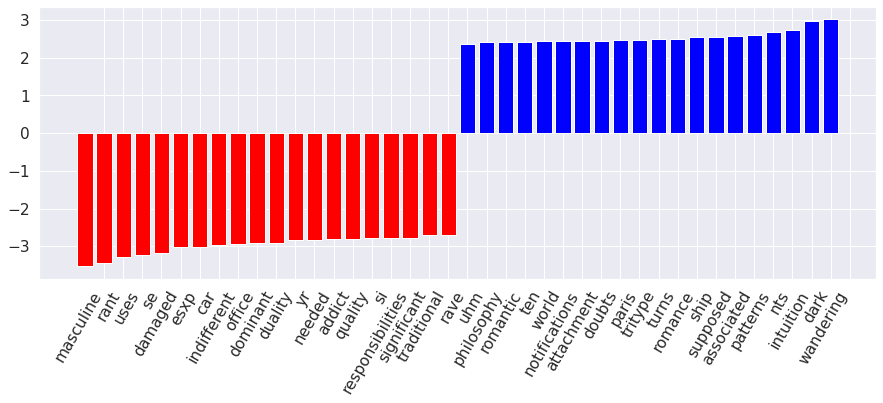

Fitting F-T
[LibLinear]
 F-T  report
               precision    recall  f1-score   support

           0       0.73      0.72      0.73       808
           1       0.76      0.77      0.77       927

    accuracy                           0.75      1735
   macro avg       0.75      0.75      0.75      1735
weighted avg       0.75      0.75      0.75      1735



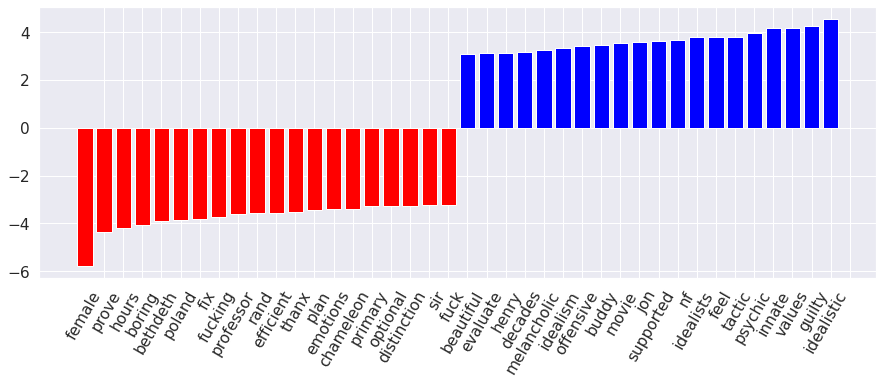

Fitting P-J
[LibLinear]
 P-J  report
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       690
           1       0.68      0.68      0.68      1045

    accuracy                           0.62      1735
   macro avg       0.60      0.60      0.60      1735
weighted avg       0.62      0.62      0.62      1735



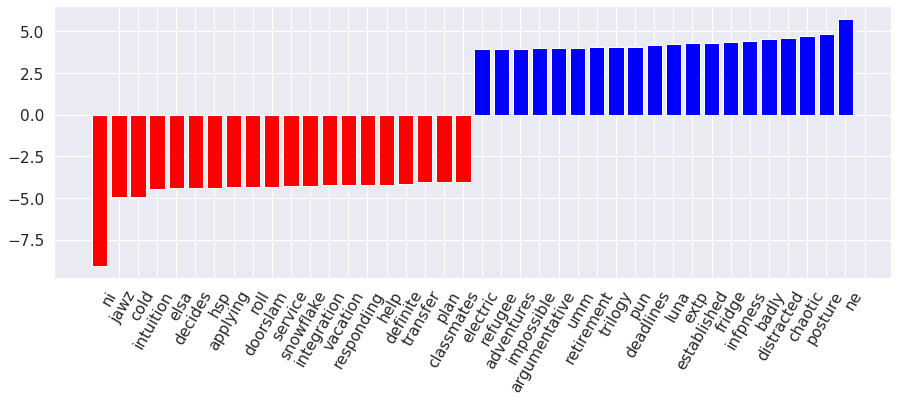

In [25]:
X = tfidf_vector
for type_trait in ("I-E", "N-S", "F-T", "P-J"):
    y = data_df[type_trait]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y, shuffle=True)
    
    print(f"Fitting {type_trait}")
    l_svc.fit(X_train, y_train)
    y_pred = l_svc.predict(X_test)
    report = classification_report(y_pred, y_test)
    print("\n", type_trait, " report\n", report)
    plot_coefficients(l_svc, cv.get_feature_names())

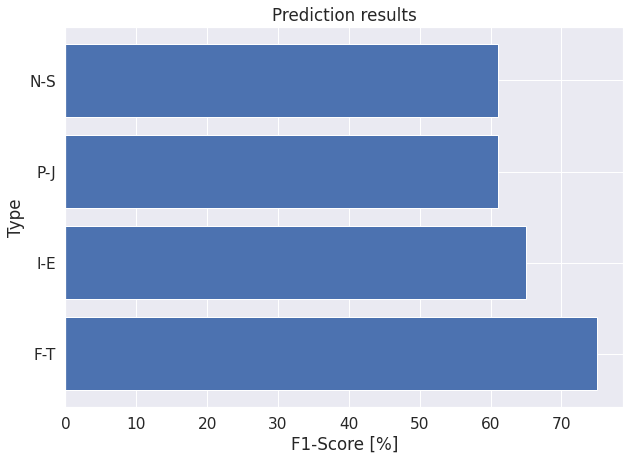

In [34]:
def show_results(values, names):
    """Visualize results by providing score values and classes names"""
    values = [value * 100 for value in values]
    values, names = zip(*sorted(list(zip(values, names))))
    
    plt.title("Prediction results")
    plt.xlabel("F1-Score [%]")
    plt.ylabel("Type")
    plt.barh(range(4), values[::-1][:], align='center')
    plt.yticks(range(4), names[::-1][:])
    plt.show()
    
show_results([0.65, 0.61, 0.75, 0.61], ["I-E", "N-S", "F-T", "P-J"])